# Reproduce Figure 13 of the 2016 JAMES Tracmip introduction paper

We use approach 1 to access the Pangeo data in the Google Cloud. See load_data_from_pangeo.iypnb in the same folder.

Note that the model median is not included here, as this would require to interpolate all data onto a common latitude grid. This is done in the 2016 JAMES paper, but here we instead work on the models' native latitude grids.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

## Data loading and climatolgical mean

Wrapper function to load data. Output is a dictionary of xarray data arrays.

In [2]:
def load_data(freq, var, exp):
    df = pd.read_csv('https://storage.googleapis.com/cmip6/tracmip.csv')
    # a somewhat cumbersome way to query the dataframe ... 
    df_var = df.query("frequency == \'"+freq+"\'").query("variable == \'"+var+"\'").query("experiment == \'"+exp+"\'")
    gcs = gcsfs.GCSFileSystem(token='anon')
    datadict = dict()
    for zstore in df_var.source.values:
        mapper = gcs.get_mapper(zstore)
        ds = xr.open_zarr(mapper, consolidated=True)
        # write only variable of interest to dictionary, so this becomes a data array
        datadict[ds.attrs['model_id']] = ds[var] 
    return datadict

Load surface temperature, precipitation and zonal wind for aquaplanet control and 4xco2 simulations.

In [3]:
ts_aqct = load_data('Amon', 'ts', 'aquaControl')
ua_aqct = load_data('Amon', 'ua', 'aquaControl')
pr_aqct = load_data('Amon', 'pr', 'aquaControl')

ts_aq4x = load_data('Amon', 'ts', 'aqua4xCO2')
ua_aq4x = load_data('Amon', 'ua', 'aqua4xCO2')
pr_aq4x = load_data('Amon', 'pr', 'aqua4xCO2')

For CALTECH model, the equivalent of the 4xCO2 simulations are the aquaAbs15 simulations.

In [4]:
ts_aq4x['CALTECH'] = load_data('Amon', 'ts', 'aquaAbs15')['CALTECH']
ua_aq4x['CALTECH'] = load_data('Amon', 'ua', 'aquaAbs15')['CALTECH']
pr_aq4x['CALTECH'] = load_data('Amon', 'pr', 'aquaAbs15')['CALTECH']

Restrict data to last 20 years, build a monthly and average over longitude. Note that this will overwrite the dictionaries.

In [5]:
def makeclim_averagelon(datadict):
    for model in datadict.keys():
        ds = datadict[model]
        ntime = ds.time.size # number of timesteps
        ds = datadict[model].isel(time=slice(ntime-20*12, ntime)).groupby('time.month').mean(['time','lon'])
        # overwrite dictionary entry 
        datadict[model] = ds

In [6]:
makeclim_averagelon(ts_aqct)
makeclim_averagelon(ts_aq4x)
makeclim_averagelon(pr_aqct)
makeclim_averagelon(pr_aq4x)
makeclim_averagelon(ua_aqct)
makeclim_averagelon(ua_aq4x)

At this point, all data will be a zonal mean climatology with 12 months.

## Calculate monthly-mean ITCZ position

In [7]:
# calculate itcz position based on precip centroid between latboundary
def get_itczposition(pr, lat, latboundary, dlat):
    # pr: precipitation
    # lat: latitudes
    # latboundary: deg N/S that are used to calculate the precip centroid
    # dlat: latitude spacing of the fine interpolated grid
    area  = np.cos(lat*np.pi/180)
    xi    = np.arange(-latboundary, latboundary, dlat)
    # need to make sure that lat increases from SP to NP
    if lat[0]>lat[1]:
        lat = lat[::-1]
        pr  = pr [::-1]
    yi    = np.interp(xi, lat, pr)
    areai = np.interp(xi, lat, area)
    # area-integrated precip (up to constant factor)
    itcz = np.NaN
    nxi = len(xi)
    tot = np.sum(yi*areai)
    yiareai_int = np.zeros(nxi) + np.nan
    for j in range(0, nxi):
        yiareai_int[j] = np.sum(np.multiply(yi[0:j+1], areai[0:j+1]))
    ixi = np.argmin(np.abs(yiareai_int - 0.5*tot))
    itcz = xi[ixi]
    return itcz

In [8]:
# dictionary of each model's monthly-mean change of the ITCZ position for 4xCO2 with respect to control
ditcz = dict()

for model in pr_aqct.keys():
    aux_aqct = np.zeros(12)
    aux_aq4x = np.zeros(12)
    for month in range(0, 12):
        aux_aqct[month] = get_itczposition(pr_aqct[model].isel(month=month), pr_aqct[model].lat, 30, 0.1)
        aux_aq4x[month] = get_itczposition(pr_aq4x[model].isel(month=month), pr_aq4x[model].lat, 30, 0.1)
    ditcz[model] = aux_aq4x - aux_aqct
    del aux_aq4x, aux_aqct

## Plotting

In [9]:
import matplotlib.pyplot as plt

In [10]:
# dictionary for model names, model numbers and model colors used in TRACMIP plots
plotdict = {'AM21'        : {'color': np.array([255,204,153])/255, 'nbr':  '1', 'name': 'AM2.1'       },
            'CAM3'        : {'color': np.array([128,128,128])/255, 'nbr':  '2', 'name': 'CAM3'        },
            'CAM4'        : {'color': np.array([148,255,181])/255, 'nbr':  '3', 'name': 'CAM4'        },
            'CAM5Nor'     : {'color': np.array([194,  0,136])/255, 'nbr':  '4', 'name': 'CAM5Nor'     },
            'CNRM-AM5'    : {'color': np.array([  0, 51,128])/255, 'nbr':  '5', 'name': 'CNRM-AM5'    },
            'ECHAM61'     : {'color': np.array([  0,117,220])/255, 'nbr':  '6', 'name': 'ECHAM6.1'    },
            'ECHAM63'     : {'color': np.array([153, 63,  0])/255, 'nbr':  '7', 'name': 'ECHAM6.3'    },
            'GISS-ModelE2': {'color': np.array([157,204,  0])/255, 'nbr':  '8', 'name': 'GISS-ModelE2'},
            'LMDZ5A'      : {'color': np.array([ 76,  0, 92])/255, 'nbr':  '9', 'name': 'LMDZ5A'      },
            'MetUM-CTL'   : {'color': np.array([ 25, 25, 25])/255, 'nbr': '10', 'name': 'MetM-CTL'    },
            'MetUM-ENT'   : {'color': np.array([  0, 92, 49])/255, 'nbr': '11', 'name': 'MetUM-ENT'   },
            'MIROC5'      : {'color': np.array([ 43,206, 72])/255, 'nbr': '12', 'name': 'MIROC5'      },
            'MPAS'        : {'color': np.array([143,124,  0])/255, 'nbr': '13', 'name': 'MPAS'        },
            'CALTECH'     : {'color': np.array([255,164,  5])/255, 'nbr': '14', 'name': 'CALTECH'     }}

/home/fd8940/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/fd8940/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/fd8940/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<Figure size 960x640 with 0 Axes>

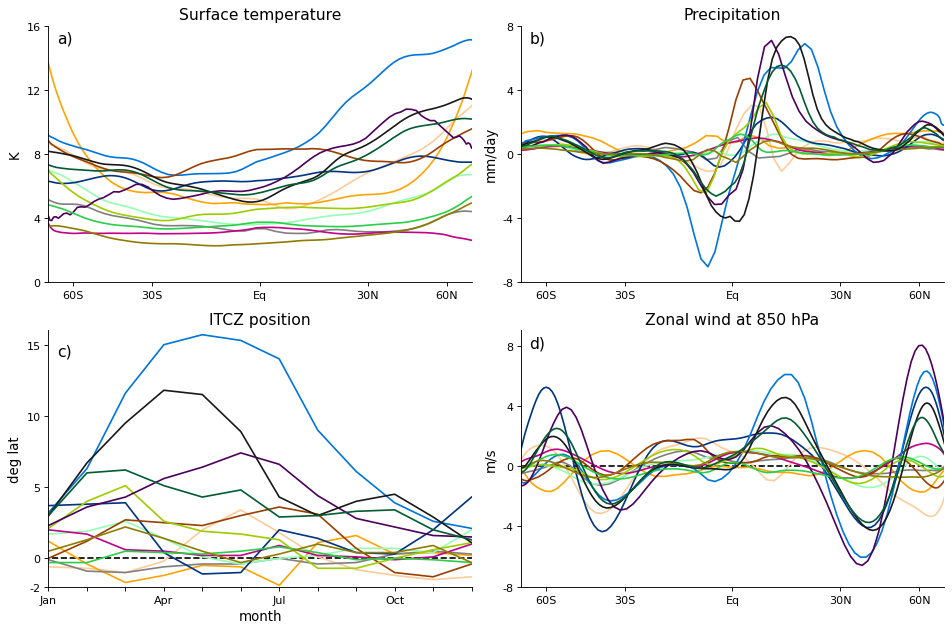

In [15]:
plt.figure( figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k' )

fig = plt.figure( figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k' )

ax = plt.subplot(2, 2, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for model in ts_aqct.keys():
    plt.plot(np.sin(ts_aqct[model].lat*np.pi/180), ts_aq4x[model].mean('month')-ts_aqct[model].mean('month'), 
             color=plotdict[model]['color'])
plt.xlim(-0.98, 0.98), plt.ylim(0, 16)
ax.xaxis.set_ticks([-0.866, -0.5, 0, 0.5, 0.866])
ax.xaxis.set_ticklabels(['60S', '30S', 'Eq', '30N', '60N'], fontsize=10)
ax.yaxis.set_ticks([0, 4, 8, 12, 16])
ax.yaxis.set_ticklabels([0, 4, 8, 12, 16], fontsize=10) 
plt.title('Surface temperature', fontsize=14)
plt.ylabel('K', fontsize=12)
plt.text(0.02, 0.95, 'a)', fontsize=14, ha='left', va='center', transform=ax.transAxes)

ax = plt.subplot(2, 2, 2)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for model in pr_aqct.keys():
    plt.plot(np.sin(pr_aqct[model].lat*np.pi/180), 
             86400*(pr_aq4x[model].mean('month')-pr_aqct[model].mean('month')), 
             color=plotdict[model]['color'])
plt.xlim(-0.98, 0.98), plt.ylim(-8, 8)
ax.xaxis.set_ticks([-0.866, -0.5, 0, 0.5, 0.866])
ax.xaxis.set_ticklabels(['60S', '30S', 'Eq', '30N', '60N'], fontsize=10)
ax.yaxis.set_ticks([-8, -4, 0, 4, 8])
ax.yaxis.set_ticklabels([-8, -4, 0, 4, 8], fontsize=10) 
plt.title('Precipitation', fontsize=14)
plt.ylabel('mm/day', fontsize=12)
plt.text(0.02, 0.95, 'b)', fontsize=14, ha='left', va='center', transform=ax.transAxes)

ax = plt.subplot(2, 2, 3)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

month=[1,2,3,4,5,6,7,8,9,10,11,12]

plt.plot([-20, 20], [0, 0], 'k--')
for model in ditcz.keys():
    plt.plot(month, ditcz[model], color=plotdict[model]['color'])
plt.xlim(1, 12), plt.ylim(-2, 16)
ax.xaxis.set_ticks(month)
ax.xaxis.set_ticklabels(['Jan', '', '', 'Apr', '', '', 'Jul', '', '' ,'Oct', '', ''], fontsize=10)
ax.yaxis.set_ticks([-2, 0, 5, 10, 15])
ax.yaxis.set_ticklabels([-2, 0, 5, 10, 15], fontsize=10) 
plt.title('ITCZ position', fontsize=14)
plt.xlabel('month', fontsize=12)
plt.ylabel('deg lat', fontsize=12)
plt.text(0.02, 0.92, 'c)', fontsize=14, ha='left', va='center', transform=ax.transAxes)
   
ax = plt.subplot(2, 2, 4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.plot([-10, 10], [0, 0], 'k--')
for model in ua_aqct.keys():
    plt.plot(np.sin(ua_aqct[model].lat*np.pi/180), 
             ua_aq4x[model].sel(plev=850e2).mean('month')-ua_aqct[model].sel(plev=850e2).mean('month'), 
             color=plotdict[model]['color'])
plt.xlim(-0.98, 0.98), plt.ylim(-8, 9)
ax.xaxis.set_ticks([-0.866, -0.5, 0, 0.5, 0.866])
ax.xaxis.set_ticklabels(['60S', '30S', 'Eq', '30N', '60N'], fontsize=10)
ax.yaxis.set_ticks([-8, -4, 0, 4, 8])
ax.yaxis.set_ticklabels([-8, -4, 0, 4, 8], fontsize=10)
plt.title('Zonal wind at 850 hPa', fontsize=14)
plt.ylabel('m/s', fontsize=12)
plt.text(0.02, 0.95, 'd)', fontsize=14, ha='left', va='center', transform=ax.transAxes, backgroundcolor='white')

plt.tight_layout()